In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from model import ResNeXt, Discriminator
from dataloader import get_dataloaders
from ssim import ssim


# Seed
manual_seed = 0
random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.use_deterministic_algorithms(True)

# Hyperparameters
lr = 0.0002
batch_size = 32
num_epochs = 20000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataloaders
train_dataloader, test_dataloader = get_dataloaders()

# Initialize models
generator = ResNeXt().to(device)
discriminator = Discriminator().to(device)

# Initialize optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Initialize BCE loss for Discriminator
criterion_d = nn.BCELoss()

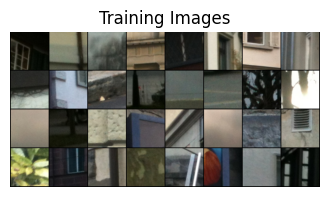

In [2]:
phone, dslr = next(iter(train_dataloader))
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Training Images")
# display the images with shape of torch.Size([3, 100, 100, 32])
plt.imshow(np.transpose(vutils.make_grid(phone), (1,2,0)))

In [3]:
# Labels
real_labels = torch.ones(32, 1).to(device)
fake_labels = torch.zeros(32, 1).to(device)
ssim_loss = 0
n_epochs = 50  # Number of epochs
for epoch in range(n_epochs):
    for i, (imgs_iphone, imgs_dslr) in enumerate(train_dataloader):

        # Adversarial ground truths
        valid = torch.ones(imgs_dslr.size(0), 1, requires_grad=False)
        fake = torch.zeros(imgs_dslr.size(0), 1, requires_grad=False)

        # Configure input
        real_imgs = imgs_dslr
        imgs_iphone = imgs_iphone

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_imgs = generator(imgs_iphone)

        # Loss measures generator's ability to fool the discriminator
        g_loss = criterion_d(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion_d(discriminator(real_imgs), valid)
        fake_loss = criterion_d(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()